### K-Means 聚类算法详解


#### 一、核心概念  
K-Means 是一种**无监督学习聚类算法**，通过将相似样本划分为K个簇（Cluster），实现数据的自动分组。其核心思想是：**“物以类聚”**，即同一簇内的样本相似度高，不同簇间的样本相似度低。  

- **关键术语**：  
  - **簇（Cluster）**：具有相似特征的样本集合；  
  - **质心（Centroid）**：每个簇的中心点（均值向量）；  
  - **距离度量**：通常用欧氏距离衡量样本与质心的相似度；  
  - **目标函数**：最小化“簇内平方和（Within-Cluster Sum of Squares, WCSS）”，即所有样本到其所属簇质心的距离平方和。  


#### 二、核心原理  
K-Means 的工作流程是一个**迭代优化过程**，分为4个步骤：  

1. **初始化**：随机选择K个样本作为初始质心（或使用K-Means++优化初始化）。  
2. **分配样本**：计算每个样本到K个质心的距离，将样本分配给距离最近的质心所在的簇。  
3. **更新质心**：计算每个簇内所有样本的均值，作为新的质心。  
4. **收敛判断**：若质心位置变化小于阈值（或达到最大迭代次数），则停止迭代；否则返回步骤2重复执行。  

最终得到K个簇，每个簇由相似样本组成，质心为簇的“代表”。  


#### 三、超参数影响  
- **`n_clusters (K)`**：簇的数量（必须指定）。K值过小会导致簇内差异大，过大则会出现冗余簇（可通过肘部法或轮廓系数选择）；  
- **`init`**：质心初始化方法（默认`k-means++`）。`k-means++`能有效避免随机初始化导致的局部最优问题；  
- **`max_iter`**：最大迭代次数（默认300）。复杂数据集需要更多迭代次数以确保收敛；  
- **`tol`**：质心变化阈值（默认1e-4）。值越小，收敛判断越严格。  


#### 四、适用场景与优缺点  
- **适用场景**：  
  - 客户分群（如电商用户消费行为聚类）；  
  - 图像压缩（将像素颜色聚类为K种主色调）；  
  - 异常检测（远离所有簇的样本视为异常）；  
  - 特征工程（用簇标签作为新特征）。  

- **优点**：  
  1. 算法简单，计算效率高（线性时间复杂度）；  
  2. 对大规模数据集友好；  
  3. 聚类结果易于解释。  

- **缺点**：  
  1. 必须提前指定K值，且对K值敏感；  
  2. 对非凸形状的簇聚类效果差；  
  3. 受异常值影响大；  
  4. 可能收敛到局部最优解。  


#### 五、代码实例（3个独立Python文件）  


##### 1. 简洁版：手撕K-Means（基础实现）  

轮廓系数：0.9084


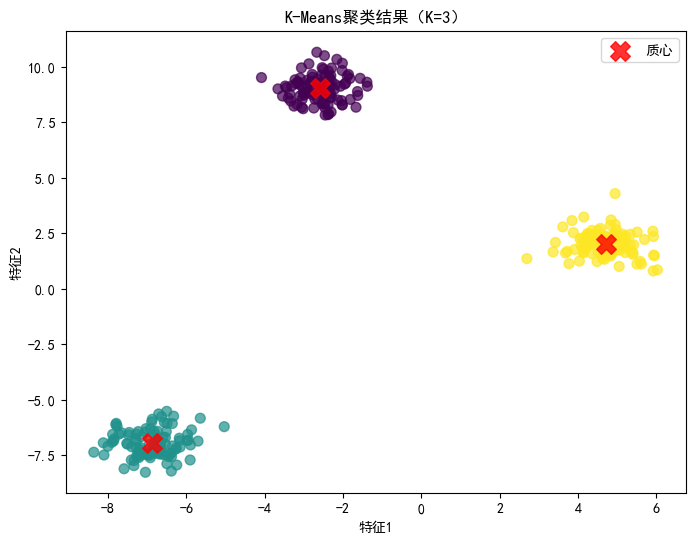

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

# 解决中文显示问题
matplotlib.rcParams["font.family"] = ["SimHei", "Microsoft YaHei"]
matplotlib.rcParams["axes.unicode_minus"] = False

class KMeans:
    def __init__(self, n_clusters=2, max_iter=100, tol=1e-4, random_state=42):
        self.n_clusters = n_clusters  # 簇的数量
        self.max_iter = max_iter      # 最大迭代次数
        self.tol = tol                # 质心变化阈值
        self.random_state = random_state
        self.centroids_ = None        # 质心
        self.labels_ = None           # 样本所属簇标签

    def fit(self, X):
        """训练模型：迭代更新质心直到收敛"""
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        # 1. 初始化质心（从样本中随机选择K个）
        self.centroids_ = X[np.random.choice(n_samples, self.n_clusters, replace=False)]

        for _ in range(self.max_iter):
            # 2. 分配样本到最近的质心
            self.labels_ = self._assign_clusters(X)

            # 3. 计算新质心
            new_centroids = np.array([X[self.labels_ == i].mean(axis=0) 
                                     for i in range(self.n_clusters)])

            # 4. 判断是否收敛（质心变化小于阈值）
            centroid_shift = np.linalg.norm(new_centroids - self.centroids_)
            if centroid_shift < self.tol:
                break

            self.centroids_ = new_centroids

    def _assign_clusters(self, X):
        """计算每个样本到质心的距离，分配到最近的簇"""
        distances = np.array([np.linalg.norm(X - centroid, axis=1) 
                             for centroid in self.centroids_])
        # 返回距离最小的质心索引（即簇标签）
        return np.argmin(distances.T, axis=1)

    def predict(self, X):
        """预测新样本的簇标签"""
        return self._assign_clusters(X)

# 测试基础版K-Means
def test_simple_kmeans():
    # 生成模拟聚类数据（3个簇）
    X, y_true = make_blobs(
        n_samples=300, centers=3, cluster_std=0.6, random_state=42
    )

    # 训练K-Means（指定K=3）
    kmeans = KMeans(n_clusters=3, max_iter=100, random_state=42)
    kmeans.fit(X)
    y_pred = kmeans.labels_

    # 评估聚类效果（轮廓系数：越接近1越好）
    print(f"轮廓系数：{silhouette_score(X, y_pred):.4f}")

    # 可视化聚类结果
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=50, cmap='viridis', alpha=0.7)
    plt.scatter(kmeans.centroids_[:, 0], kmeans.centroids_[:, 1], 
                c='red', s=200, alpha=0.8, marker='X', label='质心')
    plt.xlabel("特征1")
    plt.ylabel("特征2")
    plt.title("K-Means聚类结果（K=3）")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    test_simple_kmeans()


##### 2. 简洁版：sklearn实现K-Means（快速应用）

鸢尾花数据集轮廓系数：0.4599


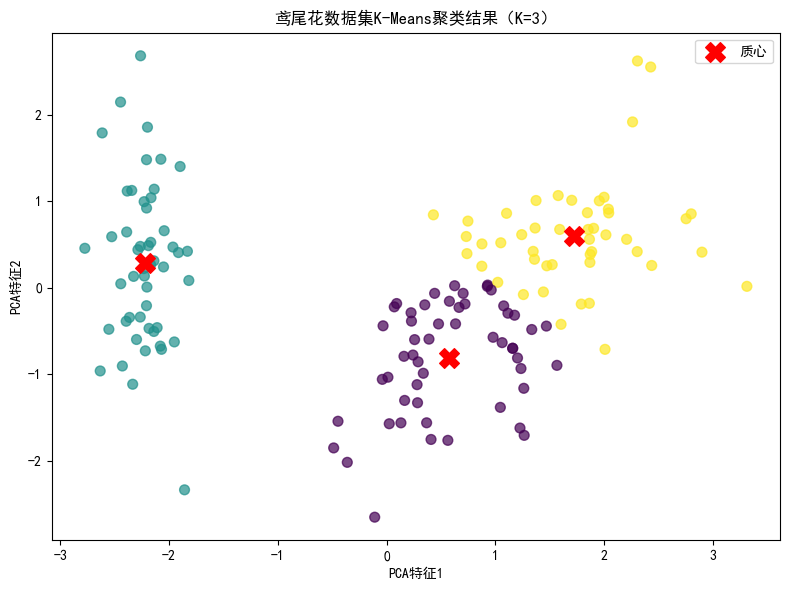

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# 解决中文显示问题
matplotlib.rcParams["font.family"] = ["SimHei", "Microsoft YaHei"]
matplotlib.rcParams["axes.unicode_minus"] = False

# 聚类鸢尾花数据集
def kmeans_iris():
    # 加载数据集
    iris = load_iris()
    X = iris.data

    # 标准化数据
    X_scaled = StandardScaler().fit_transform(X)  # K-Means必须标准化

    # 训练K-Means（使用单线程模式）
    # 初始化KMeans聚类模型实例，设置相关参数
    kmeans = KMeans(
        n_clusters=3,  # 指定聚类的簇数量为3
        init='k-means++',  # 选择质心初始化方法为k-means++，该方法能有效避免随机初始化导致的局部最优问题
        random_state=42,
        n_init=10,  # 算法会独立地以不同的质心初始化运行10次，最终选择最优结果
        max_iter=300  # 设置算法的最大迭代次数为300，防止算法因无法收敛而陷入无限循环
    )

    y_pred = kmeans.fit_predict(X_scaled)  # fit_predict 结合了 fit 和 predict 两个操作

    # 评估与输出
    # 1) metric：计算距离时使用的度量方法，默认为 'euclidean'（欧氏距离）。
    # 2) silhouette_score 用于评估聚类算法的性能。该指标通过计算每个样本的轮廓系数，然后取平均值得到整个聚类结果的得分。
    sil_score = silhouette_score(X_scaled, y_pred, metric='euclidean')
    print(f"鸢尾花数据集轮廓系数：{sil_score:.4f}")

    # PCA降维
    # 初始化PCA降维模型，将数据维度降至2维，方便可视化
    pca = PCA(n_components=2)
    # 对标准化后的特征数据X_scaled进行PCA降维操作，并将结果存储在X_pca中
    X_pca = pca.fit_transform(X_scaled)
    # 对K-Means聚类得到的质心数据进行PCA降维，确保质心和样本数据在同一维度空间，便于可视化展示
    centroids_pca = pca.transform(kmeans.cluster_centers_)

    # 可视化
    plt.figure(figsize=(8, 6))
    # c=y_pred 依据K-Means聚类得到的标签为每个样本点着色
    # cmap='viridis' 使用viridis颜色映射，使不同簇的样本点颜色区分明显
    # s=50 设置样本点的大小为50
    # alpha=0.7 设置样本点的透明度为0.7，让图形更美观
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis', s=50, alpha=0.7)
    # marker 参数用于指定散点图中每个数据点的形状
    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
                c='red', s=200, marker='X', label='质心')
    plt.xlabel("PCA特征1")
    plt.ylabel("PCA特征2")
    plt.title("鸢尾花数据集K-Means聚类结果（K=3）")
    plt.legend()
    plt.tight_layout()
    plt.show()

kmeans_iris()

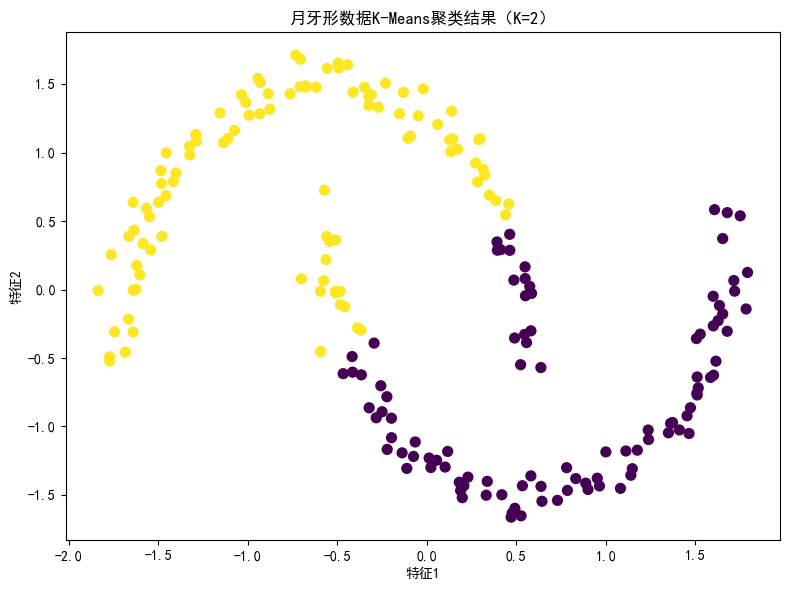

注：月牙形等非凸分布数据不适合K-Means，聚类效果较差


In [7]:
# 生成月牙形的非凸分布数据集测试非凸形状数据
def kmeans_nonconvex():
    # 1) make_moons 是 sklearn.datasets 模块中的一个函数，用于生成月牙形状的样本数据集。这种数据集常用于测试聚类算法、分类算法对非凸形状数据的处理能力，因为 K-Means 等基于距离的算法在处理这类非凸数据时效果通常不佳。
    # 2) n_samples=200 表示生成的样本数量为200个
    # 3) noise=0.05 表示添加到数据中的高斯噪声的标准差为0.05
    X, y_true = make_moons(n_samples=200, noise=0.05, random_state=42)

    X_scaled = StandardScaler().fit_transform(X)

    # n_clusters=2：指定聚类的簇数量为2
    # n_init=10：算法会独立地以不同的质心初始化运行10次，最终选择最优结果
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)

    y_pred = kmeans.fit_predict(X_scaled)

    plt.figure(figsize=(8, 6))
    # c=y_pred 依据K-Means聚类得到的标签为每个样本点着色
    # cmap='viridis' 使用viridis颜色映射，使不同簇的样本点颜色区分明显
    # s=50 设置样本点的大小为50
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_pred, cmap='viridis', s=50)

    plt.title("月牙形数据K-Means聚类结果（K=2）")
    plt.xlabel("特征1")
    plt.ylabel("特征2")
    plt.tight_layout()
    plt.show()
    print("注：月牙形等非凸分布数据不适合K-Means，聚类效果较差")

kmeans_nonconvex()

##### 3. 全面版：sklearn实现（参数调优+多场景测试）

=== 参数调优分析 ===
参数组合性能对比（前5名）：
   K      初始化方法  最大迭代    轮廓系数      WCSS
1  4  k-means++   100  0.6474  184.4729
5  4  k-means++   300  0.6474  184.4729
4  3  k-means++   300  0.6448  349.1817
0  3  k-means++   100  0.6448  349.1817
6  5  k-means++   300  0.5864  145.6075


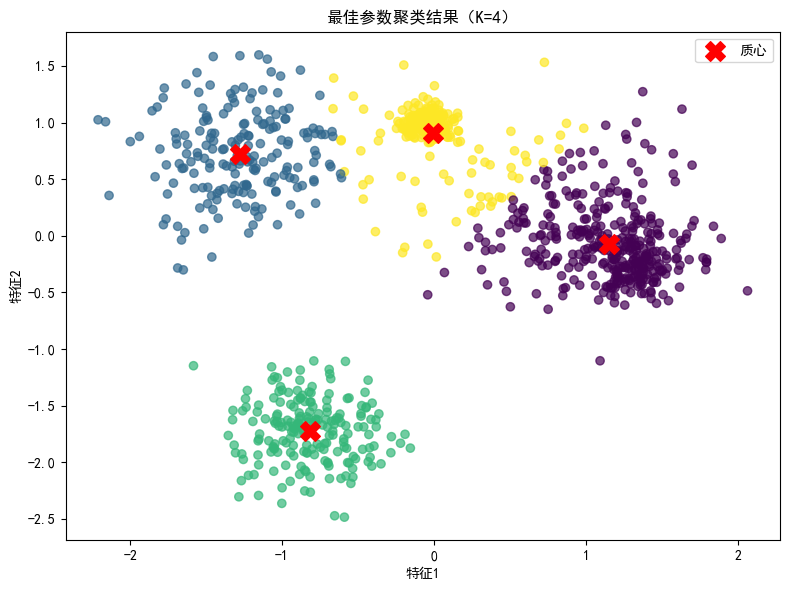

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import warnings
import pandas as pd

# 1. 优先设置环境变量（必须在导入sklearn之前）
os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # 限制CPU核心数
os.environ["OMP_NUM_THREADS"] = "1"     # 禁用OpenMP多线程
os.environ["MKL_NUM_THREADS"] = "1"     # 限制MKL库线程数
os.environ["NUMEXPR_NUM_THREADS"] = "1" # 限制数值表达式线程数

# 2. 精准屏蔽KMeans特定警告
warnings.filterwarnings(
    "ignore", 
    category=UserWarning, 
    message="KMeans is known to have a memory leak on Windows with MKL.*"
)

# 3. 导入sklearn组件
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs, load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.model_selection import ParameterGrid

# 解决中文显示问题
matplotlib.rcParams["font.family"] = ["SimHei", "Microsoft YaHei"]
matplotlib.rcParams["axes.unicode_minus"] = False

# 1. 聚类性能随参数变化的分析
def kmeans_parameter_analysis():
    # 生成复杂聚类数据
    X, y_true = make_blobs(
        n_samples=1000, centers=5, cluster_std=[0.5, 1, 1.5, 2, 2.5], 
        random_state=42
    )
    X_scaled = StandardScaler().fit_transform(X)

    # 测试不同参数组合（精简网格避免过多警告源）
    param_grid = {
        'n_clusters': [3, 4, 5, 6],
        'init': ['k-means++'],  # 仅保留更优的初始化方法
        'max_iter': [100, 300]
    }

    results = []
    for params in ParameterGrid(param_grid):
        # 单线程模式运行KMeans
        kmeans = KMeans(
            **params,
            random_state=42,
            n_init=5  # 适当减少初始化次数，减少警告触发
        )
        y_pred = kmeans.fit_predict(X_scaled)
        results.append({
            'K': params['n_clusters'],
            '初始化方法': params['init'],
            '最大迭代': params['max_iter'],
            '轮廓系数': silhouette_score(X_scaled, y_pred),
            'WCSS': kmeans.inertia_
        })

    # 展示结果（按轮廓系数排序）
    results_df = pd.DataFrame(results)
    print("参数组合性能对比（前5名）：")
    print(results_df.sort_values('轮廓系数', ascending=False).head(5).round(4))

    # 可视化最佳参数的聚类结果
    best_params = results_df.loc[results_df['轮廓系数'].idxmax()].to_dict()
    best_kmeans = KMeans(
        n_clusters=int(best_params['K']),
        init=best_params['初始化方法'],
        max_iter=int(best_params['最大迭代']),
        random_state=42,
        n_init=5
    )
    y_pred = best_kmeans.fit_predict(X_scaled)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_pred, cmap='viridis', alpha=0.7)
    plt.scatter(best_kmeans.cluster_centers_[:, 0], best_kmeans.cluster_centers_[:, 1],
                c='red', s=200, marker='X', label='质心')
    plt.title(f"最佳参数聚类结果（K={best_params['K']}）")
    plt.xlabel("特征1")
    plt.ylabel("特征2")
    plt.legend()
    plt.tight_layout()
    plt.show()

print("=== 参数调优分析 ===")
kmeans_parameter_analysis()


=== 手写数字聚类 ===

手写数字数据集轮廓系数：0.1356


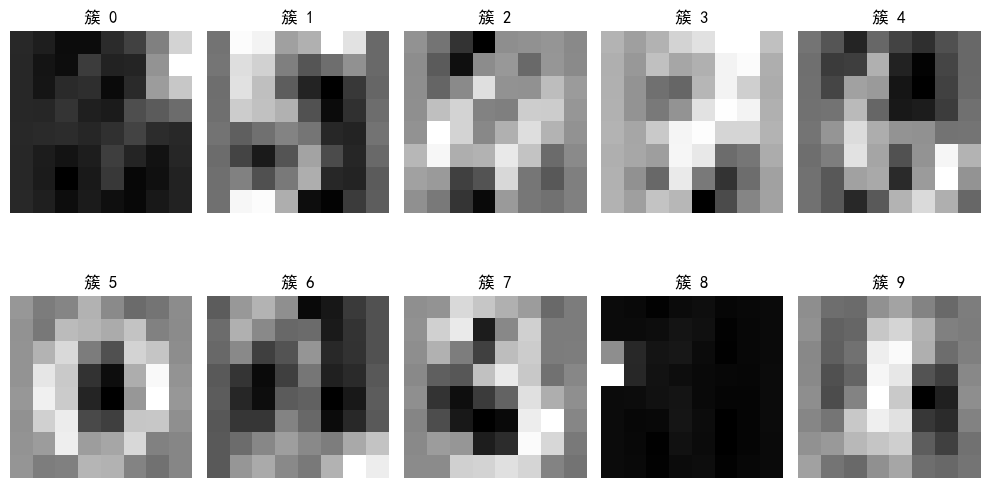

In [9]:
# 2. 实际数据集聚类（手写数字）
def kmeans_digits_clustering():
    # 加载手写数字数据集（8x8像素图像）
    digits = load_digits()
    X = digits.data
    X_scaled = StandardScaler().fit_transform(X)

    # 聚类（假设K=10，与数字类别数一致）
    kmeans = KMeans(
        n_clusters=10, 
        init='k-means++', 
        n_init=5,  # 减少初始化次数
        random_state=42
    )
    y_pred = kmeans.fit_predict(X_scaled)

    # 评估
    print(f"\n手写数字数据集轮廓系数：{silhouette_score(X_scaled, y_pred):.4f}")

    # 可视化每个簇的质心（可视为"平均数字"）
    plt.figure(figsize=(10, 6))
    for i in range(10):
        centroid = kmeans.cluster_centers_[i].reshape(8, 8)  # 还原为8x8图像
        plt.subplot(2, 5, i+1)
        plt.imshow(centroid, cmap='gray')
        plt.title(f"簇 {i}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\n=== 手写数字聚类 ===")
kmeans_digits_clustering()

### 总结  
K-Means 是最经典的聚类算法之一，因其简单高效成为无监督学习的入门首选。实践中需注意以下关键点：  

1.** 数据预处理 **：必须对特征进行标准化（如`StandardScaler`），否则尺度大的特征会主导距离计算；  
2.** K值选择 **：结合肘部法（WCSS突变点）和轮廓系数（平均相似度）确定最佳K，避免主观判断；  
3.** 初始化方法 **：优先使用`k-means++`替代随机初始化，减少陷入局部最优的概率；  
4.** 适用场景 **：适合凸形分布的簇，对非凸数据（如月牙形）效果较差，可考虑DBSCAN等算法。  